In [2]:
from pymongo import MongoClient
# from sshtunnel import SSHTunnelForwarder
import pymongo
from tqdm import tqdm
import os
import re

import numpy as np
import pandas as pd

import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
! nvidia-smi

Sat Jul  2 12:54:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   37C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# MongoDB

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_us = db.rm_patent_us
    db_rm_cn = db.rm_patent_cn
    db_rm_de = db.rm_patent_de
    
    db_rm_us_2020 = db.rm_patent_us_2020
    db_rm_cn_2020 = db.rm_patent_cn_2020
    db_rm_de_2020 = db.rm_patent_de_2020
    
except errors.ConnectionFailure as err:
    print(err)

In [6]:
db_rm_de

Collection(Database(MongoClient(host=['140.117.69.70:30241'], document_class=dict, tz_aware=False, connect=True, authmechanism='SCRAM-SHA-1'), 'eva'), 'rm_patent_de')

# DE Data

In [7]:
data_5 = pd.read_csv("../rm_company_country_de_5.csv")
data_10 = pd.read_csv("../rm_company_country_de_10.csv")

In [8]:
data_5.head()

,company,AT,BR,CA,CH,CN,DE,DK,EP,ES,...,JP,KR,LT,PL,PT,RS,SG,TW,US,WO
0,Advantech Service IoT GmbH,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1,Apple Inc,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,Armstrong DLW GmbH,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Audi AG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DLOG GES fur ELEKTRONISCHE DATENTECHNIK MBH,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [9]:
data_10.head()

,company,AR,AT,AU,BE,BR,CA,CH,CN,CZ,...,MX,NO,PL,PT,RU,SE,SG,TW,US,WO
0,ACO Severin Ahlmann GmbH and Co KG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,ALBA GROUP PLC & Co KG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AT&S Austria Technologie and Systemtechnik AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,AU Optronics Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,Accell Group NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data_all = pd.concat([data_5,data_10], join='outer')

In [11]:
data_all.fillna(value=0, inplace=True)
data_all

,company,AT,BR,CA,CH,CN,DE,DK,EP,ES,...,EA,FI,FR,IL,LU,MA,MX,NO,RU,SE
0,Advantech Service IoT GmbH,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Apple Inc,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Armstrong DLW GmbH,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Audi AG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DLOG GES fur ELEKTRONISCHE DATENTECHNIK MBH,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,Zhuhai Hotdoor Technology Co Ltd,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
327,Zolitron Tech GmbH,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
328,Zolitron Technology GmbH,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329,Zumtobel Lighting GmbH Germany,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_sum = pd.DataFrame(np.sum(data_all.values, axis=0), columns=['sum'])

In [13]:
df_sum["row"]=list(data_all.columns)

In [14]:
df_sum

,sum,row
0,Advantech Service IoT GmbHApple IncArmstrong D...,company
1,16.0,AT
2,17.0,BR
3,41.0,CA
4,10.0,CH
5,530.0,CN
6,1473.0,DE
7,10.0,DK
8,265.0,EP
9,29.0,ES


In [15]:
# 找出總數top10的country
de_country_top10 = df_sum.iloc[1:,:].sort_values(by=['sum'],ascending=False).head(11)
de_country_top10

,sum,row
6,1473.0,DE
23,660.0,WO
22,569.0,US
5,530.0,CN
8,265.0,EP
15,205.0,KR
14,153.0,JP
21,57.0,TW
10,49.0,GB
3,41.0,CA


In [16]:
de_country_top10 = de_country_top10[de_country_top10["row"]!="WO"]
de_country_top10

,sum,row
6,1473.0,DE
22,569.0,US
5,530.0,CN
8,265.0,EP
15,205.0,KR
14,153.0,JP
21,57.0,TW
10,49.0,GB
3,41.0,CA
20,31.0,SG


In [17]:
de_country_top10["ratio"] = de_country_top10.apply(lambda x: round(x["sum"]/sum(list(df_sum.iloc[1:,:]["sum"]))*100,1), axis=1)

/tmp/ipykernel_4166/3696183871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_country_top10["ratio"] = de_country_top10.apply(lambda x: round(x["sum"]/sum(list(df_sum.iloc[1:,:]["sum"]))*100,1), axis=1)


In [18]:
de_country_top10

,sum,row,ratio
6,1473.0,DE,34.7
22,569.0,US,13.4
5,530.0,CN,12.5
8,265.0,EP,6.2
15,205.0,KR,4.8
14,153.0,JP,3.6
21,57.0,TW,1.3
10,49.0,GB,1.2
3,41.0,CA,1.0
20,31.0,SG,0.7


# US Data

In [19]:
data_5 = pd.read_csv("../rm_company_country_us_5.csv")
data_10 = pd.read_csv("../rm_company_country_us_10.csv")

In [20]:
data_5.head()

,company,AR,AU,BR,CA,CN,DE,DK,EA,EC,...,PT,RS,RU,SA,SE,SG,TW,US,WO,ZA
0,3d-Oxides,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,ABB Schweiz AG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,ADVANERGY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,AFI Licensing LLC,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,AFIRMA CONSULTING & TECHNOLOGIES SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [21]:
data_10.head()

,company,AP,AR,AT,AU,BE,BG,BR,CA,CH,...,RU,SE,SG,SI,TN,TR,TW,US,WO,ZA
0,#glowontech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,10353744 Canada Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10757616 Canada Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,12a Systems Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0


In [22]:
data_all = pd.concat([data_5,data_10], join='outer')

In [23]:
data_all.fillna(value=0, inplace=True)
data_all

,company,AR,AU,BR,CA,CN,DE,DK,EA,EC,...,IE,IT,LT,LU,NO,PE,RO,SI,TN,TR
0,3d-Oxides,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABB Schweiz AG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADVANERGY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AFI Licensing LLC,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AFIRMA CONSULTING & TECHNOLOGIES SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4627,incNETWORKS Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4628,mSignia Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4629,nChain Holdings Ltd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4630,u-blox AG,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
df_sum = pd.DataFrame(np.sum(data_all.values, axis=0), columns=['sum'])

In [25]:
df_sum["row"]=list(data_all.columns)

In [26]:
# 找出總數top10的country
us_country_top10 = df_sum.iloc[1:,:].sort_values(by=['sum'],ascending=False).head(11)
us_country_top10 = us_country_top10[us_country_top10["row"]!="WO"]
us_country_top10

,sum,row
36,42336.0,US
5,14176.0,CN
10,14050.0,EP
21,7497.0,KR
20,5177.0,JP
35,2557.0,TW
4,1581.0,CA
3,1265.0,BR
2,1138.0,AU
6,1071.0,DE


In [27]:
us_country_top10["ratio"] = us_country_top10.apply(lambda x: round(x["sum"]/sum(list(df_sum.iloc[1:,:]["sum"]))*100,1), axis=1)

In [28]:
us_country_top10

,sum,row,ratio
36,42336.0,US,36.5
5,14176.0,CN,12.2
10,14050.0,EP,12.1
21,7497.0,KR,6.5
20,5177.0,JP,4.5
35,2557.0,TW,2.2
4,1581.0,CA,1.4
3,1265.0,BR,1.1
2,1138.0,AU,1.0
6,1071.0,DE,0.9


# CN Data

In [29]:
data_5 = pd.read_csv("../rm_company_country_cn_5.csv")
data_10 = pd.read_csv("../rm_company_country_cn_10.csv")

In [30]:
data_5.head()

,company,AP,AR,AU,BR,CA,CL,CN,CO,CR,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
0,001 Engineering Co ltdqingdao Construction Group,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1st Engineering Co Ltd of MBEC,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2nd Engineering Co Ltd of MBEC,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
4,3M innovation intellectual property Co.,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [31]:
data_10.head()

,company,AR,AT,AU,BE,BR,CA,CH,CL,CN,...,RU,SE,SG,SI,TR,TW,US,UY,WO,ZA
0,1230 Intelligent Technology Haian Co ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,"5G IP HOLDINGS, LLC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,63921 Troops of PLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,720 Health Beijing Itech Health Co ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
data_all = pd.concat([data_5,data_10], join='outer')

In [33]:
data_all.fillna(value=0, inplace=True)
data_all

,company,AP,AR,AU,BR,CA,CL,CN,CO,CR,...,UA,US,UY,WO,ZA,AT,BE,CH,FI,RO
0,001 Engineering Co ltdqingdao Construction Group,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1st Engineering Co Ltd of MBEC,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2nd Engineering Co Ltd of MBEC,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3M innovation intellectual property Co.,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10184,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10185,iDevices LLC,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10186,iRobot Corp,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
10187,nChain Holdings Ltd,0.0,0.0,4.0,4.0,4.0,0.0,8.0,0.0,0.0,...,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
df_sum = pd.DataFrame(np.sum(data_all.values, axis=0), columns=['sum'])

In [35]:
df_sum["row"]=list(data_all.columns)

In [36]:
# 找出總數top10的country
cn_country_top10 = df_sum.iloc[1:,:].sort_values(by=['sum'],ascending=False).head(11)
cn_country_top10 = cn_country_top10[cn_country_top10["row"]!="WO"]
cn_country_top10

,sum,row
7,53070.0,CN
57,6881.0,US
17,6573.0,EP
31,3087.0,KR
30,2989.0,JP
55,1142.0,TW
5,966.0,CA
4,896.0,BR
3,829.0,AU
50,491.0,SG


In [37]:
cn_country_top10["ratio"] = cn_country_top10.apply(lambda x: round(x["sum"]/sum(list(df_sum.iloc[1:,:]["sum"]))*100,1), axis=1)

In [38]:
cn_country_top10

,sum,row,ratio
7,53070.0,CN,59.2
57,6881.0,US,7.7
17,6573.0,EP,7.3
31,3087.0,KR,3.4
30,2989.0,JP,3.3
55,1142.0,TW,1.3
5,966.0,CA,1.1
4,896.0,BR,1.0
3,829.0,AU,0.9
50,491.0,SG,0.5


# 畫出各國country barchart

In [39]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}%'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

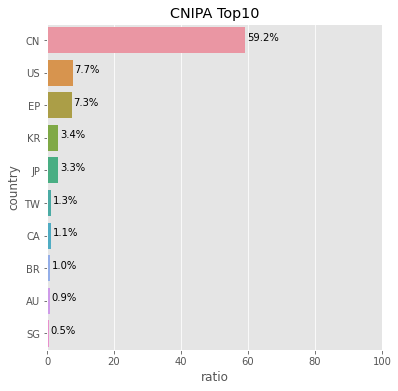

In [40]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

p = sns.barplot(x='ratio', y='row', data=cn_country_top10)
show_values(p, "h", space=0.5)
plt.xticks(range(0,101,20))

plt.xlabel("ratio")
plt.ylabel("country")
plt.title("CNIPA Top10")


plt.show()

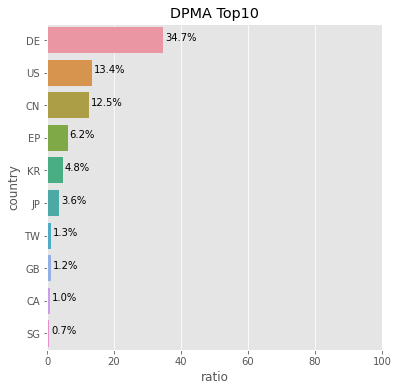

In [41]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

p = sns.barplot(x='ratio', y='row', data=de_country_top10)
show_values(p, "h", space=0.5)
plt.xticks(range(0,101,20))

plt.xlabel("ratio")
plt.ylabel("country")
plt.title("DPMA Top10")

plt.show()

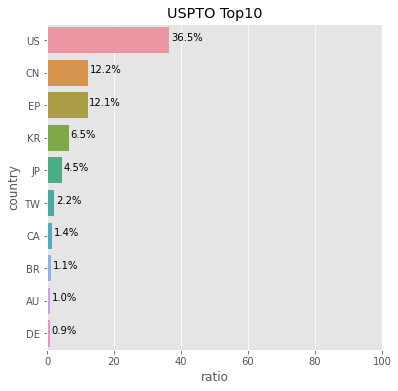

In [42]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')

p = sns.barplot(x='ratio', y='row', data=us_country_top10)
show_values(p, "h", space=0.5)
plt.xticks(range(0,101,20))

plt.xlabel("ratio")
plt.ylabel("country")
plt.title("USPTO Top10")

plt.show()

# 分別計算各國各年分country數量

## DE

In [ ]:
de_ls = []
for i in range(2010,2021):
    try:
        country_df = pd.read_csv("rm_company_country_de_{}.csv".format(i))
        
        c_ls = []
        for k in country_ls:
            try:
                # print(np.sum(country_df.loc[:,k].values, axis=0))
                c_ls.append(np.sum(country_df.loc[:,k].values, axis=0))
            except:    
                c_ls.append(0)
        
        print(i,c_ls)
        de_ls.append(c_ls)
    except:
        # print(i,list(np.zeros(10)))
        print(i,"=============================")
        de_ls.append(list(np.zeros(10)))

2010 =============================
2011 =============================
2012 [12.0, 17.0, 6.0, 0, 0, 5.0, 0, 0, 0, 0]
2013 [7.0, 3.0, 6.0, 6.0, 0, 2.0, 0, 0, 0, 0]
2014 [75.0, 7.0, 129.0, 1.0, 0, 8.0, 1.0, 0, 0, 2.0]
2015 [78.0, 15.0, 1.0, 8.0, 19.0, 4.0, 10.0, 0, 6.0, 38.0]
2016 [441.0, 98.0, 30.0, 17.0, 0, 16.0, 18.0, 4.0, 9.0, 12.0]
2017 [1027.0, 324.0, 166.0, 46.0, 50.0, 50.0, 21.0, 36.0, 42.0, 6.0]
2018 [1217.0, 428.0, 154.0, 132.0, 21.0, 50.0, 58.0, 122.0, 63.0, 145.0]
2019 [665.0, 363.0, 237.0, 79.0, 35.0, 64.0, 57.0, 57.0, 77.0, 56.0]
2020 [538.0, 802.0, 121.0, 45.0, 55.0, 55.0, 15.0, 463.0, 38.0, 58.0]


In [ ]:
de_ls

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [12.0, 17.0, 6.0, 0, 0, 5.0, 0, 0, 0, 0],
 [7.0, 3.0, 6.0, 6.0, 0, 2.0, 0, 0, 0, 0],
 [75.0, 7.0, 129.0, 1.0, 0, 8.0, 1.0, 0, 0, 2.0],
 [78.0, 15.0, 1.0, 8.0, 19.0, 4.0, 10.0, 0, 6.0, 38.0],
 [441.0, 98.0, 30.0, 17.0, 0, 16.0, 18.0, 4.0, 9.0, 12.0],
 [1027.0, 324.0, 166.0, 46.0, 50.0, 50.0, 21.0, 36.0, 42.0, 6.0],
 [1217.0, 428.0, 154.0, 132.0, 21.0, 50.0, 58.0, 122.0, 63.0, 145.0],
 [665.0, 363.0, 237.0, 79.0, 35.0, 64.0, 57.0, 57.0, 77.0, 56.0],
 [538.0, 802.0, 121.0, 45.0, 55.0, 55.0, 15.0, 463.0, 38.0, 58.0]]

In [ ]:
de_df = pd.DataFrame(de_ls, index=list(range(2010,2021)), columns=country_ls)
de_df

,H04,G06,H01,G01,A61,Y02,G08,B60,G05,H03
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,12.0,17.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2013,7.0,3.0,6.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0
2014,75.0,7.0,129.0,1.0,0.0,8.0,1.0,0.0,0.0,2.0
2015,78.0,15.0,1.0,8.0,19.0,4.0,10.0,0.0,6.0,38.0
2016,441.0,98.0,30.0,17.0,0.0,16.0,18.0,4.0,9.0,12.0
2017,1027.0,324.0,166.0,46.0,50.0,50.0,21.0,36.0,42.0,6.0
2018,1217.0,428.0,154.0,132.0,21.0,50.0,58.0,122.0,63.0,145.0
2019,665.0,363.0,237.0,79.0,35.0,64.0,57.0,57.0,77.0,56.0


## CN

In [ ]:
cn_ls = []
for i in range(2010,2021):
    try:
        country_df = pd.read_csv("rm_company_country_cn_{}.csv".format(i))
        
        c_ls = []
        for k in country_ls:
            try:
                # print(np.sum(country_df.loc[:,k].values, axis=0))
                c_ls.append(np.sum(country_df.loc[:,k].values, axis=0))
            except:    
                c_ls.append(0)
        
        print(i,c_ls)
        cn_ls.append(c_ls)
    except:
        # print(i,list(np.zeros(10)))
        print("=============================")
        cn_ls.append(list(np.zeros(10)))

2010 [74.0, 5.0, 4.0, 4.0, 48.0, 34.0, 0, 7.0, 5.0, 15.0]
2011 [148.0, 18.0, 212.0, 24.0, 197.0, 142.0, 0, 49.0, 3.0, 0]
2012 [171.0, 13.0, 659.0, 67.0, 202.0, 112.0, 0, 18.0, 10.0, 7.0]
2013 [207.0, 63.0, 181.0, 85.0, 127.0, 114.0, 0, 147.0, 34.0, 19.0]
2014 [269.0, 80.0, 104.0, 50.0, 147.0, 75.0, 40.0, 125.0, 8.0, 0]
2015 [1089.0, 277.0, 136.0, 98.0, 228.0, 134.0, 67.0, 22.0, 60.0, 2.0]
2016 [6956.0, 1597.0, 840.0, 390.0, 330.0, 426.0, 287.0, 134.0, 178.0, 114.0]
2017 [22074.0, 3693.0, 1280.0, 1112.0, 627.0, 1105.0, 937.0, 396.0, 623.0, 394.0]
2018 [27768.0, 4027.0, 1191.0, 1696.0, 617.0, 1223.0, 1266.0, 350.0, 895.0, 436.0]
2019 [23179.0, 5094.0, 1147.0, 2009.0, 445.0, 1472.0, 1179.0, 279.0, 716.0, 132.0]
2020 [15040.0, 7296.0, 1176.0, 2342.0, 502.0, 1524.0, 1293.0, 307.0, 690.0, 133.0]


In [ ]:
cn_ls

[[74.0, 5.0, 4.0, 4.0, 48.0, 34.0, 0, 7.0, 5.0, 15.0],
 [148.0, 18.0, 212.0, 24.0, 197.0, 142.0, 0, 49.0, 3.0, 0],
 [171.0, 13.0, 659.0, 67.0, 202.0, 112.0, 0, 18.0, 10.0, 7.0],
 [207.0, 63.0, 181.0, 85.0, 127.0, 114.0, 0, 147.0, 34.0, 19.0],
 [269.0, 80.0, 104.0, 50.0, 147.0, 75.0, 40.0, 125.0, 8.0, 0],
 [1089.0, 277.0, 136.0, 98.0, 228.0, 134.0, 67.0, 22.0, 60.0, 2.0],
 [6956.0, 1597.0, 840.0, 390.0, 330.0, 426.0, 287.0, 134.0, 178.0, 114.0],
 [22074.0, 3693.0, 1280.0, 1112.0, 627.0, 1105.0, 937.0, 396.0, 623.0, 394.0],
 [27768.0, 4027.0, 1191.0, 1696.0, 617.0, 1223.0, 1266.0, 350.0, 895.0, 436.0],
 [23179.0, 5094.0, 1147.0, 2009.0, 445.0, 1472.0, 1179.0, 279.0, 716.0, 132.0],
 [15040.0, 7296.0, 1176.0, 2342.0, 502.0, 1524.0, 1293.0, 307.0, 690.0, 133.0]]

In [ ]:
cn_df = pd.DataFrame(cn_ls, index=list(range(2010,2021)), columns=country_ls)
cn_df

,H04,G06,H01,G01,A61,Y02,G08,B60,G05,H03
2010,74.0,5.0,4.0,4.0,48.0,34.0,0.0,7.0,5.0,15.0
2011,148.0,18.0,212.0,24.0,197.0,142.0,0.0,49.0,3.0,0.0
2012,171.0,13.0,659.0,67.0,202.0,112.0,0.0,18.0,10.0,7.0
2013,207.0,63.0,181.0,85.0,127.0,114.0,0.0,147.0,34.0,19.0
2014,269.0,80.0,104.0,50.0,147.0,75.0,40.0,125.0,8.0,0.0
2015,1089.0,277.0,136.0,98.0,228.0,134.0,67.0,22.0,60.0,2.0
2016,6956.0,1597.0,840.0,390.0,330.0,426.0,287.0,134.0,178.0,114.0
2017,22074.0,3693.0,1280.0,1112.0,627.0,1105.0,937.0,396.0,623.0,394.0
2018,27768.0,4027.0,1191.0,1696.0,617.0,1223.0,1266.0,350.0,895.0,436.0
2019,23179.0,5094.0,1147.0,2009.0,445.0,1472.0,1179.0,279.0,716.0,132.0


## US

In [ ]:
us_ls = []
for i in range(2010,2021):
    try:
        country_df = pd.read_csv("rm_company_country_us_{}.csv".format(i))
        
        c_ls = []
        for k in country_ls:
            try:
                # print(np.sum(country_df.loc[:,k].values, axis=0))
                c_ls.append(np.sum(country_df.loc[:,k].values, axis=0))
            except:    
                c_ls.append(0)
        
        print(i,c_ls)
        us_ls.append(c_ls)
    except:
        # print(i,list(np.zeros(10)))
        print("=============================")
        us_ls.append(list(np.zeros(10)))

2010 [86.0, 30.0, 14.0, 12.0, 0, 2.0, 0, 0, 0, 0]
2011 [544.0, 67.0, 19.0, 5.0, 2.0, 11.0, 4.0, 0, 0, 3.0]
2012 [940.0, 62.0, 10.0, 12.0, 0, 32.0, 5.0, 16.0, 3.0, 0]
2013 [881.0, 80.0, 46.0, 23.0, 0, 26.0, 10.0, 0, 4.0, 5.0]
2014 [3526.0, 749.0, 457.0, 85.0, 103.0, 95.0, 52.0, 29.0, 43.0, 19.0]
2015 [10495.0, 3562.0, 1069.0, 362.0, 282.0, 340.0, 233.0, 70.0, 182.0, 168.0]
2016 [18470.0, 6489.0, 2427.0, 590.0, 821.0, 455.0, 422.0, 153.0, 438.0, 345.0]
2017 [28819.0, 10359.0, 3058.0, 1253.0, 1381.0, 678.0, 912.0, 467.0, 523.0, 968.0]
2018 [46629.0, 17070.0, 3587.0, 1661.0, 1808.0, 994.0, 953.0, 996.0, 982.0, 1987.0]
2019 [61580.0, 24818.0, 3278.0, 2556.0, 2052.0, 1151.0, 1604.0, 2072.0, 1425.0, 1187.0]
2020 [50896.0, 17677.0, 3372.0, 2039.0, 1935.0, 894.0, 899.0, 1986.0, 927.0, 1350.0]


In [ ]:
us_ls

[[86.0, 30.0, 14.0, 12.0, 0, 2.0, 0, 0, 0, 0],
 [544.0, 67.0, 19.0, 5.0, 2.0, 11.0, 4.0, 0, 0, 3.0],
 [940.0, 62.0, 10.0, 12.0, 0, 32.0, 5.0, 16.0, 3.0, 0],
 [881.0, 80.0, 46.0, 23.0, 0, 26.0, 10.0, 0, 4.0, 5.0],
 [3526.0, 749.0, 457.0, 85.0, 103.0, 95.0, 52.0, 29.0, 43.0, 19.0],
 [10495.0, 3562.0, 1069.0, 362.0, 282.0, 340.0, 233.0, 70.0, 182.0, 168.0],
 [18470.0, 6489.0, 2427.0, 590.0, 821.0, 455.0, 422.0, 153.0, 438.0, 345.0],
 [28819.0, 10359.0, 3058.0, 1253.0, 1381.0, 678.0, 912.0, 467.0, 523.0, 968.0],
 [46629.0,
  17070.0,
  3587.0,
  1661.0,
  1808.0,
  994.0,
  953.0,
  996.0,
  982.0,
  1987.0],
 [61580.0,
  24818.0,
  3278.0,
  2556.0,
  2052.0,
  1151.0,
  1604.0,
  2072.0,
  1425.0,
  1187.0],
 [50896.0,
  17677.0,
  3372.0,
  2039.0,
  1935.0,
  894.0,
  899.0,
  1986.0,
  927.0,
  1350.0]]

In [ ]:
us_df = pd.DataFrame(us_ls, index=list(range(2010,2021)), columns=country_ls)
us_df

,H04,G06,H01,G01,A61,Y02,G08,B60,G05,H03
2010,86.0,30.0,14.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0
2011,544.0,67.0,19.0,5.0,2.0,11.0,4.0,0.0,0.0,3.0
2012,940.0,62.0,10.0,12.0,0.0,32.0,5.0,16.0,3.0,0.0
2013,881.0,80.0,46.0,23.0,0.0,26.0,10.0,0.0,4.0,5.0
2014,3526.0,749.0,457.0,85.0,103.0,95.0,52.0,29.0,43.0,19.0
2015,10495.0,3562.0,1069.0,362.0,282.0,340.0,233.0,70.0,182.0,168.0
2016,18470.0,6489.0,2427.0,590.0,821.0,455.0,422.0,153.0,438.0,345.0
2017,28819.0,10359.0,3058.0,1253.0,1381.0,678.0,912.0,467.0,523.0,968.0
2018,46629.0,17070.0,3587.0,1661.0,1808.0,994.0,953.0,996.0,982.0,1987.0
2019,61580.0,24818.0,3278.0,2556.0,2052.0,1151.0,1604.0,2072.0,1425.0,1187.0


# 計算各國country類別總數量

In [ ]:
us_5 = pd.read_csv("../rm_company_country_us_5.csv")
us_10 = pd.read_csv("../rm_company_country_us_10.csv")

In [ ]:
us_all = pd.concat([us_5,us_10], join='outer')

In [ ]:
len(list(us_all.columns))-1

118

In [ ]:
de_5 = pd.read_csv("../rm_company_country_de_us_5.csv")
de_10 = pd.read_csv("../rm_company_country_de_us_10.csv")

In [ ]:
de_all = pd.concat([de_5,de_10], join='outer')

In [ ]:
len(list(de_all.columns))-1

121

In [ ]:
cn_5 = pd.read_csv("../rm_company_country_cn_us_5.csv")
cn_10 = pd.read_csv("../rm_company_country_cn_us_10.csv")

In [ ]:
cn_all = pd.concat([cn_5,cn_10], join='outer')

In [ ]:
len(list(cn_all.columns))-1

125

In [ ]:
country_df = pd.read_csv("rm_company_country_us_2018.csv")

In [ ]:
country_df

,company,A01,A21,A23,A41,A42,A43,A45,A46,A47,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
1,2689090 Canada Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
2,2you Io Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
3,3M Innovative Properties Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3a Logics Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,Zuna Inc,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
1526,Zyter Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0
1527,eBay Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1528,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0
